In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

### Récupération des données


In [45]:
box1temoin = pd.read_csv('/users/2024/ds2/118004830/Documents/Box1_Temoin.csv')
box2hydrique = pd.read_csv('/users/2024/ds2/118004830/Documents/Box2_Stress_hydrique.csv')
box3salin = pd.read_csv('/users/2024/ds2/118004830/Documents/Box3_stress_salin.csv')
box4temoin = pd.read_csv('/users/2024/ds2/118004830/Documents/Box4_Temoin.csv')

## Graphique des signaux

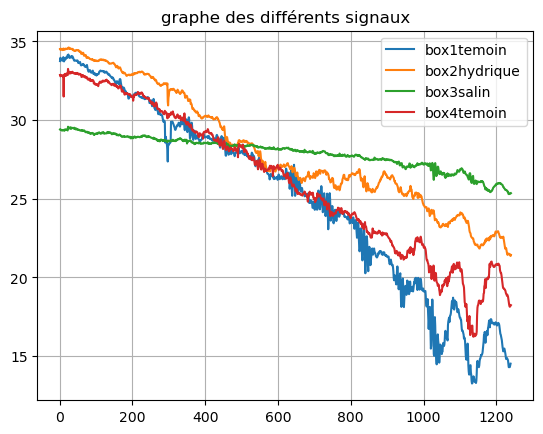

In [46]:
X1, Y1= box1temoin['X'], box1temoin['Y']
X2, Y2= box2hydrique['X'], box2hydrique['Y']
X3, Y3= box3salin['X'], box3salin['Y']
X4, Y4= box4temoin['X'], box4temoin['Y']


plt.plot(X1,Y1)
plt.plot(X2,Y2)
plt.plot(X3,Y3)
plt.plot(X4,Y4)
plt.title('graphe des différents signaux')
plt.legend(['box1temoin','box2hydrique','box3salin','box4temoin'])
plt.grid()
plt.show()

Chaque jour on doit récupérer G(pente), C(analyse harmonique) et HDR(dépend de l'énergie).  
Une prise Te toutes les 15min, on fait par jour.  
Tous les 96 points.  


### 1) Fonction régression - tendance journalière

In [47]:
def regre(box):
    pentes=[]
    Xdep, Ydep= [], []
    for i in range(0, len(box['X']), 96):
        Xdep.append(box['X'][i])
        Ydep.append(box['Y'][i])
        #print(Xdep)
        #print(Ydep)
        
        X=box['X'][i:i+95].to_list()
        Y=box['Y'][i:i+95].to_list()
        
        X = np.array(X).reshape(-1, 1)
        Y = np.array(Y).reshape(-1, 1)
        
        reg = LinearRegression()
        reg.fit(X, Y)
        pente = reg.coef_[0][0]
        pentes.append(pente)
    return pentes, Xdep, Ydep

regre(box1temoin)[0]
#plt.plot(regre(box1temoin))

[-0.010996003639417691,
 -0.016201503359462494,
 -0.016433093505039204,
 0.0020724230123180276,
 -0.010321867301231807,
 -0.014862616181410973,
 -0.00907272676371781,
 -0.012783777995520723,
 -0.035068208286674146,
 -0.03336196668533036,
 -0.05709426651735723,
 -0.049241765117581195,
 -0.010972566887803459]

Il faut print chaque baton a la suite des autres.  
prendre les coos X Y de chaque début de segment, puis appliquer le coeff directeur sur 96 nouvelles valeurs.

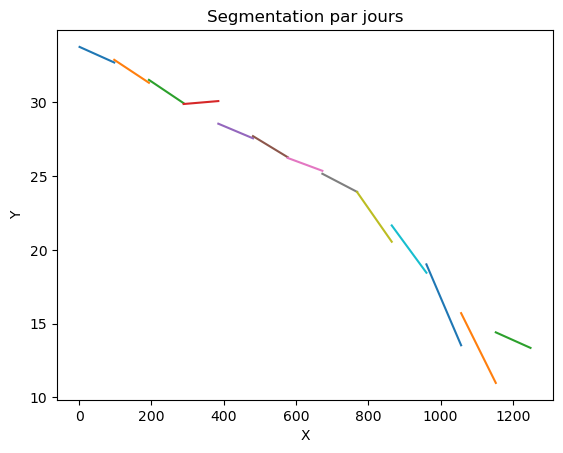

([1, 97, 193, 289, 385, 481, 577, 673, 769, 865, 961, 1057, 1153],
 [33.7466,
  32.8729,
  31.5136,
  29.8794,
  28.5457,
  27.7028,
  26.2257,
  25.1552,
  23.9168,
  21.654,
  19.0165,
  15.7126,
  14.4118],
 [-0.010996003639417691,
  -0.016201503359462494,
  -0.016433093505039204,
  0.0020724230123180276,
  -0.010321867301231807,
  -0.014862616181410973,
  -0.00907272676371781,
  -0.012783777995520723,
  -0.035068208286674146,
  -0.03336196668533036,
  -0.05709426651735723,
  -0.049241765117581195,
  -0.010972566887803459])

In [48]:
def regre_and_plot(box):
    pentes = []   #vecteur qui contient les coeff directeurs de chacunes des pentes journalières
    Xdep, Ydep = [], []    #vecteurs qui stockent les coordonnées de départ de chzque journée

    for i in range(0, len(box['X']), 96):
        Xdep.append(box['X'][i])
        Ydep.append(box['Y'][i])

        X = box['X'][i:i+95].to_list()
        Y = box['Y'][i:i+95].to_list()

        X = np.array(X).reshape(-1, 1)
        Y = np.array(Y).reshape(-1, 1)

        reg = LinearRegression()   #application de la régression sur chacune des journées
        reg.fit(X, Y)
        pente = reg.coef_[0][0]
        pentes.append(pente)

        # Générer les coordonnées du segment
        M = 96  # Longueur du segment 
        X_segment = [Xdep[-1]]
        Y_segment = [Ydep[-1]]

        for j in range(1, M+1):
            x_point = Xdep[-1] + j
            y_point = Ydep[-1] + j * pente
            X_segment.append(x_point)
            Y_segment.append(y_point)

        # Tracer le segment
        plt.plot(X_segment, Y_segment)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Segmentation par jours')
    plt.show()
    return Xdep, Ydep, pentes

# Exemple d'utilisation avec box1temoin
regre_and_plot(box1temoin)


### 2) Calculs des C(n)

On commence par faire la soustraction sur les Y des coeffs directeurs.  
tant que il reste 96 (faire en sorte que ca fasse le derniere aussi):  
valeur de 1 à 96 prend la valeur Y - coeff  
changement de coeff1  
97 à .. - coeff2  
on a un nouveau Y  

peut etre creer nouvelle colonne dans la data frame pour Ynew  

In [49]:
periode = np.linspace(0, len(box1temoin)-1, len(box1temoin))
pas = periode[1] - periode[0]  
T=96


# Fonctions coefficients de la série de Fourier
def a(n,box):
    return sum((box['Y'])* np.cos(2 * np.pi * n * periode / T) * pas) * 2 / T * (1 / 2 * (n == 0) + 1 * (n != 0))

def b(n,box):
    return sum((box['Y']) * np.sin(2 * np.pi * n * periode / T) * pas) * 2 / T


# Fonction pour calculer les coefficients c(n) de la série de Fourier
def c(n,box):
    a_coeffs = [a(i,box) for i in range(1,n+1)]
    b_coeffs = [b(i,box) for i in range(1,n+1)]

    # Calcul des coefficients c(n)
    c_coeffs = [np.sqrt(a_coeffs[i] ** 2 + b_coeffs[i] ** 2) for i in range(n)]

    # Retourne les indices (n) et les coefficients c(n)
    return c_coeffs

print(c(15,box1temoin))

[13.395710879954157, 5.150294199979768, 4.0277145772387755, 2.8338964266505777, 2.9729969279755473, 2.816153569663454, 1.7123256366683848, 1.4697839433309807, 1.1925344444817418, 0.5668547879635671, 0.6937051419929529, 0.8501947427044673, 1.3998315631767386, 0.9125699361486418, 1.188303252949646]


### 3) Calcul de HDR

## Création du tableau de coordonnées  
faure tableau Gr H C